In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Notes

##### Stride = 1 to capture detailed information <br>Padding=1 "akenaha size=same fi tensor flow"<br>ReLU was used to introduce non-linearity (Do not suffer from vanishing gradient like tanh,sigmoid  + computationally efficient)<br>
- **Convolutional Layer:** Extracts features.
- **ReLU (or other non-linearity):** Introduces non-linearity.
- **Pooling Layer (Max Pooling):** Reduces dimensionality.


In [ ]:
class VGG(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
class MobileNet(nn.Module):
    def __init__(self, num_classes=4):
        super(MobileNet, self).__init__()
        def conv_dw(in_channels, out_channels, stride):
            return nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),

            *[conv_dw(512, 512, 1) for _ in range(5)],

            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),

            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        return torch.cat([branch1, branch2, branch3, branch4], 1)

class Inception(nn.Module):
    def __init__(self, num_classes=4):
        super(Inception, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)

        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            self._make_layer(in_channels + i * growth_rate, growth_rate)
            for i in range(num_layers)
        ])

    def _make_layer(self, in_channels, growth_rate):
        return nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_feature = layer(torch.cat(features, 1))
            features.append(new_feature)
        return torch.cat(features, 1)

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.layer = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.layer(x)

class DenseNet(nn.Module):
    def __init__(self, num_classes=4, growth_rate=32, block_layers=[6, 12, 24, 16]):
        super(DenseNet, self).__init__()
        self.init_conv = nn.Conv2d(3, 2 * growth_rate, kernel_size=7, stride=2, padding=3, bias=False)

        num_channels = 2 * growth_rate
        self.features = nn.ModuleList()

        for i, num_layers in enumerate(block_layers):
            self.features.append(DenseBlock(num_layers, num_channels, growth_rate))
            num_channels += num_layers * growth_rate
            if i != len(block_layers) - 1:
                self.features.append(TransitionLayer(num_channels, num_channels // 2))
                num_channels //= 2

        self.bn = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x):
        x = self.init_conv(x)
        for layer in self.features:
            x = layer(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
def get_dataloaders(batch_size=64, data_dir="D:\\Koleya\\Assignments\\cv assignments\\ass4\\archive\\Master Folder"):
    """
    Creates train, validation, and test dataloaders from the specified directory structure.
    """
    train_dir = f"{data_dir}\\train"
    val_dir = f"{data_dir}\\valid"
    test_dir = f"{data_dir}\\test"

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize all images to 224x224
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize images
    ])

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load datasets
    train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate(model, train_loader, val_loader, device, num_epochs=25, learning_rate=0.001, patience=5):
    """
    Train the model and evaluate it with early stopping.
    Returns the classification report and confusion matrix.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    patience_counter = 0  # Counter to track epochs without improvement
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}")

        # Evaluate on validation set after each epoch
        val_loss = evaluate(model, val_loader, criterion, device)
        print(f"Validation Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter
            # Save model with best validation loss
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered. Stopping training.")
                break

    # Load the best model after training
    model.load_state_dict(torch.load('best_model.pth'))

    # Final evaluation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    target_names = [str(i) for i in range(4)]
    report = classification_report(all_labels, all_preds, target_names=target_names, digits=4)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    return report, conf_matrix

def evaluate(model, val_loader, criterion, device):
    """
    Evaluate the model on the validation set and return the average loss.
    """
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    return val_loss / len(val_loader)


In [ ]:
if torch.cuda.is_available():
    print("CUDA is available! Running on GPU.")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available! Running on GPU.
Device Name: NVIDIA GeForce RTX 3070 Laptop GPU


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def get_dataloaders(data_dir, batch_size=32, shuffle=True):
    """
    Load training, validation, and test DataLoaders from specified folders.
    Data augmentation is applied to the training set.

    Args:
        data_dir (str): Path to the dataset directory containing 'train', 'valid', and 'test' folders.
        batch_size (int): Batch size for DataLoaders.
        shuffle (bool): Whether to shuffle the training dataset.

    Returns:
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        test_loader (DataLoader): DataLoader for the test set.
    """
    # Define transformations for training data (including augmentation)
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),      # Resize all images to 224x224 (VGG requirement)
        transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
        transforms.RandomRotation(20),      # Randomly rotate images by up to 20 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
        transforms.ToTensor(),              # Convert PIL image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize like ImageNet
    ])

    # Define transformations for validation and test data (no augmentation)
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),      # Resize all images to 224x224
        transforms.ToTensor(),              # Convert PIL image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize like ImageNet
    ])

    # Define directories for train, validation, and test sets
    train_dir = f"{data_dir}\\train"
    val_dir = f"{data_dir}\\valid"
    test_dir = f"{data_dir}\\test"

    # Load datasets from the respective directories with transformations
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

    # Create DataLoaders for each dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [ ]:
# Define dataset directory
data_dir = "D:\\Koleya\\Assignments\\cv assignments\\ass4\\archive\\Master Folder"

# Get DataLoaders
train_loader, val_loader, test_loader = get_dataloaders(data_dir, batch_size=32, shuffle=True)

# Check dataset sizes
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")

# Check class labels
print(f"Class-to-Index Mapping: {train_loader.dataset.classes}")

# Example: Iterate through a batch in the training DataLoader
for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}")  # Example: torch.Size([32, 3, 224, 224])
    print(f"Batch labels: {labels}")             # Example: tensor([0, 1, 2, 3, ...])
    break

Number of training samples: 1000
Number of validation samples: 36
Number of test samples: 38
Class-to-Index Mapping: ['Angry', 'Other', 'Sad', 'happy']
Batch image shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([1, 0, 1, 2, 3, 0, 0, 1, 3, 2, 2, 3, 2, 0, 1, 2, 2, 2, 3, 3, 1, 3, 1, 0,
        2, 3, 3, 0, 1, 2, 0, 2])


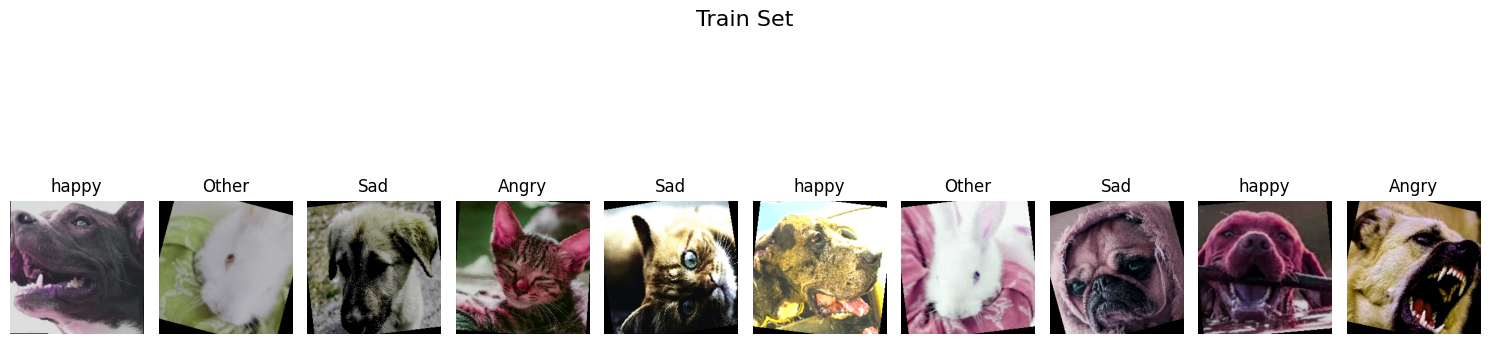

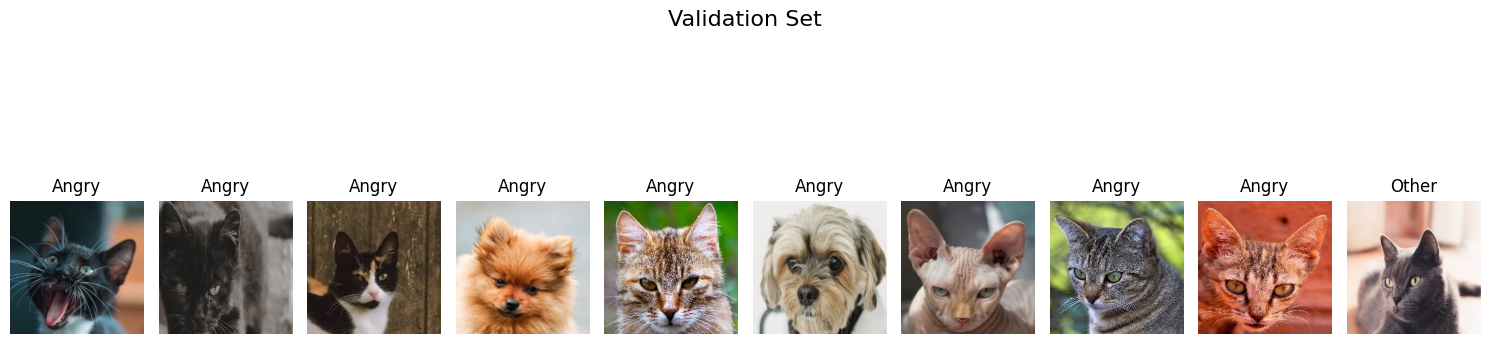

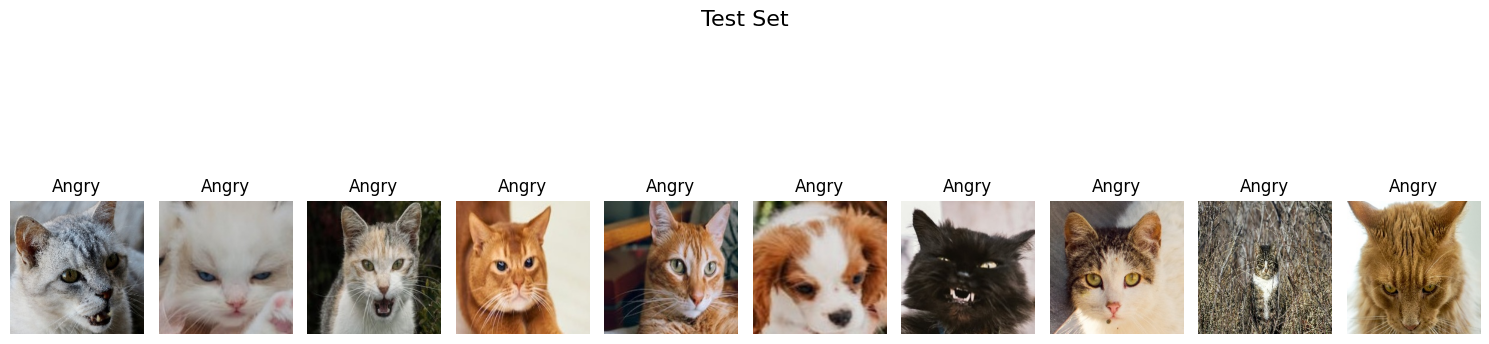

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def show_images_from_loader(data_loader, class_names, title, num_images=10):
    """
    Visualize a few images from a DataLoader.

    Args:
        data_loader (DataLoader): The DataLoader to sample images from.
        class_names (list): List of class names corresponding to labels.
        title (str): Title of the visualization (e.g., "Train Set").
        num_images (int): Number of images to display.
    """
    # Get a single batch of images and labels
    images, labels = next(iter(data_loader))

    # Limit to `num_images` images
    images = images[:num_images]
    labels = labels[:num_images]

    # Denormalize the images for visualization
    images = images * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    images = images.clamp(0, 1)  # Clamp values to [0, 1] range

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        ax = axes[i]
        img = images[i].permute(1, 2, 0).numpy()  # Convert to HWC format for matplotlib
        ax.imshow(img)
        ax.set_title(class_names[labels[i].item()])
        ax.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Load the DataLoaders
data_dir = "D:\\Koleya\\Assignments\\cv assignments\\ass4\\archive\\Master Folder"
train_loader, val_loader, test_loader = get_dataloaders(data_dir, batch_size=32, shuffle=True)

# Get the class names
class_names = train_loader.dataset.classes

# Visualize samples from each dataset
show_images_from_loader(train_loader, class_names, "Train Set")
show_images_from_loader(val_loader, class_names, "Validation Set")
show_images_from_loader(test_loader, class_names, "Test Set")


In [ ]:
import torch
import numpy as np


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader, test_loader = get_dataloaders(batch_size=64)

    models_to_train = {
        #"VGG": VGG,
        #"ResNet": ResNet,
        # "MobileNet": MobileNet,
        # "Inception": Inception,
        # "DenseNet": DenseNet,
    }

    reports = {}
    confusion_matrices = {}
    accuracies = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for model_name, model_class in models_to_train.items():
        print(f"\nTraining {model_name}...")
        model = model_class(num_classes=4).to(device)

        # Train and evaluate the model
        report, conf_matrix = train_and_evaluate(model, train_loader, val_loader, device)

        # Save the report and confusion matrix
        reports[model_name] = report
        confusion_matrices[model_name] = conf_matrix

        # Parse the metrics from the report dictionary
        # Ensure `output_dict=True` in `classification_report` in `train_and_evaluate`
        report_dict = report  # report should already be a dictionary
        accuracies.append(report_dict["accuracy"])  # Overall accuracy
        precision_scores.append(
            np.mean([score["precision"] for label, score in report_dict.items() if label.isdigit()])
        )
        recall_scores.append(
            np.mean([score["recall"] for label, score in report_dict.items() if label.isdigit()])
        )
        f1_scores.append(
            np.mean([score["f1-score"] for label, score in report_dict.items() if label.isdigit()])
        )

        print(f"Finished {model_name}\n")

    # Print a summary of the metrics for all models
    for i, model_name in enumerate(models_to_train.keys()):
        print(f"Model: {model_name}")
        print(f"  Accuracy: {accuracies[i]:.4f}")
        print(f"  Mean Precision: {precision_scores[i]:.4f}")
        print(f"  Mean Recall: {recall_scores[i]:.4f}")
        print(f"  Mean F1-Score: {f1_scores[i]:.4f}")
        print()



Training MobileNet...
Epoch 1/25, Loss: 1.4384
Validation Loss: 1.9457
Epoch 2/25, Loss: 1.4655
Validation Loss: 1.3791
Epoch 3/25, Loss: 1.4109
Validation Loss: 1.3861
Epoch 4/25, Loss: 1.3954
Validation Loss: 1.4005
Epoch 5/25, Loss: 1.3985
Validation Loss: 1.4007
Epoch 6/25, Loss: 1.3904
Validation Loss: 1.3868
Epoch 7/25, Loss: 1.3898
Validation Loss: 1.3893
Early stopping triggered. Stopping training.


C:\Users\02rad\AppData\Local\Temp\ipykernel_18016\2412737524.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         9
           1     0.0000    0.0000    0.0000         6
           2     0.0000    0.0000    0.0000        10
           3     0.3056    1.0000    0.4681        11

    accuracy                         0.3056        36
   macro avg     0.0764    0.2500    0.1170        36
weighted avg     0.0934    0.3056    0.1430        36


Confusion Matrix:
[[ 0  0  0  9]
 [ 0  0  0  6]
 [ 0  0  0 10]
 [ 0  0  0 11]]


C:\Users\02rad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\02rad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\02rad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

TypeError: string indices must be integers, not 'str'

In [ ]:
# Print summary
print("\nSummary of Results:")
for model_name in models_to_train.keys():
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {reports[model_name]['accuracy']:.4f}")
    print(f"Precision: {reports[model_name]['precision']:.4f}")
    print(f"Recall: {reports[model_name]['recall']:.4f}")
    print(f"F1-score: {reports[model_name]['f1']:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrices[model_name]}")

# Calculate mean average metrics
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print("\nMean Average of All Models:")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-score: {mean_f1:.4f}")


In [ ]:
import json
with open('model_reports.json', 'w') as f:
    json.dump({'reports': reports, 'confusion_matrices': confusion_matrices}, f)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Define the VGG class here (from your previous code)

# Function to train and evaluate the model
def train_and_evaluate(model, train_loader, val_loader, test_loader, num_epochs=15, learning_rate=0.001, device='cuda'):
    """
    Train and evaluate the model, collecting metrics for later comparison.

    Args:
        model (nn.Module): The PyTorch model to train and evaluate.
        train_loader (DataLoader): The DataLoader for the training dataset.
        val_loader (DataLoader): The DataLoader for the validation dataset.
        test_loader (DataLoader): The DataLoader for the test dataset.
        num_epochs (int): Number of epochs for training.
        learning_rate (float): Learning rate for the optimizer.
        device (str): Device to run the model on ('cuda' or 'cpu').

    Returns:
        reports (dict): Dictionary containing metrics for later use.
    """
    # Move model to the device (GPU or CPU)
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Store metrics
    reports = {}
    confusion_matrices = {}
    accuracies = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

        # Evaluate on the validation set after each epoch
        val_accuracy, val_precision, val_recall, val_f1, val_conf_matrix = evaluate_model(model, val_loader, device)

        # Store metrics
        accuracies.append(val_accuracy)
        precision_scores.append(val_precision)
        recall_scores.append(val_recall)
        f1_scores.append(val_f1)
        confusion_matrices[f"epoch_{epoch+1}"] = val_conf_matrix

        print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

    # Evaluate the model on the test set
    test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = evaluate_model(model, test_loader, device)

    reports["test"] = {
        "accuracy": test_accuracy,
        "precision": test_precision,
        "recall": test_recall,
        "f1_score": test_f1,
        "confusion_matrix": test_conf_matrix
    }

    return reports, confusion_matrices, accuracies, precision_scores, recall_scores, f1_scores

def evaluate_model(model, data_loader, device='cuda'):
    """
    Evaluate the model on a dataset (train, validation, or test).

    Args:
        model (nn.Module): The trained PyTorch model.
        data_loader (DataLoader): DataLoader for the dataset to evaluate.
        device (str): Device to run the model on ('cuda' or 'cpu').

    Returns:
        accuracy (float): Accuracy of the model on the dataset.
        precision (float): Precision of the model on the dataset.
        recall (float): Recall of the model on the dataset.
        f1_score (float): F1 score of the model on the dataset.
        confusion_matrix (np.ndarray): Confusion matrix of the model on the dataset.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in tqdm(data_loader, desc="Evaluating", unit="batch"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return accuracy, precision, recall, f1, conf_matrix

# Load Data
data_dir = "D:\\Koleya\\Assignments\\cv assignments\\ass4\\archive\\Master Folder"
train_loader, val_loader, test_loader = get_dataloaders(data_dir, batch_size=64, shuffle=True)

# Instantiate the model
num_classes = 4
model = VGG(num_classes=num_classes)  # Using the VGG model defined earlier

# Train and evaluate the model
reports, confusion_matrices, accuracies, precision_scores, recall_scores, f1_scores = train_and_evaluate(
    model, train_loader, val_loader, test_loader, num_epochs=15, learning_rate=0.001, device='cuda'
)

# Save the reports
import pickle

with open('reports.pkl', 'wb') as f:
    pickle.dump(reports, f)

with open('confusion_matrices.pkl', 'wb') as f:
    pickle.dump(confusion_matrices, f)

# Optionally, print the final test metrics
print(f"Final Test Accuracy: {reports['test']['accuracy']:.4f}")
print(f"Final Test Precision: {reports['test']['precision']:.4f}")
print(f"Final Test Recall: {reports['test']['recall']:.4f}")
print(f"Final Test F1 Score: {reports['test']['f1_score']:.4f}")


Epoch 1/15: 100%|██████████| 16/16 [09:13<00:00, 34.61s/batch]


Epoch [1/15], Loss: 1.5236105844378471


Evaluating: 100%|██████████| 1/1 [00:03<00:00,  4.00s/batch]
C:\Users\02rad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.2778, Precision: 0.0772, Recall: 0.2778, F1 Score: 0.1208


Epoch 2/15: 100%|██████████| 16/16 [09:24<00:00, 35.29s/batch]


Epoch [2/15], Loss: 1.3908585086464882


Evaluating: 100%|██████████| 1/1 [00:04<00:00,  4.01s/batch]
C:\Users\02rad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.1667, Precision: 0.0278, Recall: 0.1667, F1 Score: 0.0476


Epoch 3/15: 100%|██████████| 16/16 [09:23<00:00, 35.20s/batch]


Epoch [3/15], Loss: 1.386703297495842


Evaluating: 100%|██████████| 1/1 [00:03<00:00,  3.94s/batch]
C:\Users\02rad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.2778, Precision: 0.0772, Recall: 0.2778, F1 Score: 0.1208


Epoch 4/15:  88%|████████▊ | 14/16 [24:26:11<14:41:29, 26444.62s/batch]